<a href="https://colab.research.google.com/github/the-faisalahmed/Optimization/blob/main/Graph_Problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

!pip install pyomo
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.opt import SolverStatus
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import itertools
import networkx as nx
from pyomo.contrib.latex_printer import latex_printer


In [2]:
def Solve(model,solver):
  # Solve model
  opt = SolverFactory(solver)
  result = opt.solve(model)

  if (result.solver.status == SolverStatus.ok) and \
      (result.solver.termination_condition == TerminationCondition.optimal):
      # Do something when the solution in optimal and feasible
      print('Solution is Optimal')
  elif (result.solver.termination_condition == TerminationCondition.infeasible):
      # Do something when model in infeasible
      print('Solution is Infeasible')
  else:
          # Something else is wrong
      print("Solver Status:",  result.solver.status)

  # Solve time
  print('Solve Time: ', result.solver.wallclock_time)

# **Maximum Flow Problem**

Find the maximum flow possible from a source to a sink in a flow network.

\begin{aligned}
& \text{maximize} & & \sum_{(i,j) \in E} X_{ij} \\
& \text{subject to} & &  X_{ij} \leq C_{ij} \quad & \forall (i, j) \in E \\
& & & \sum_{j} X_{ij} - \sum_{j} X_{ji} = 0 \quad & \forall i \in \{0,1,\ldots,n\} \\
\end{aligned}

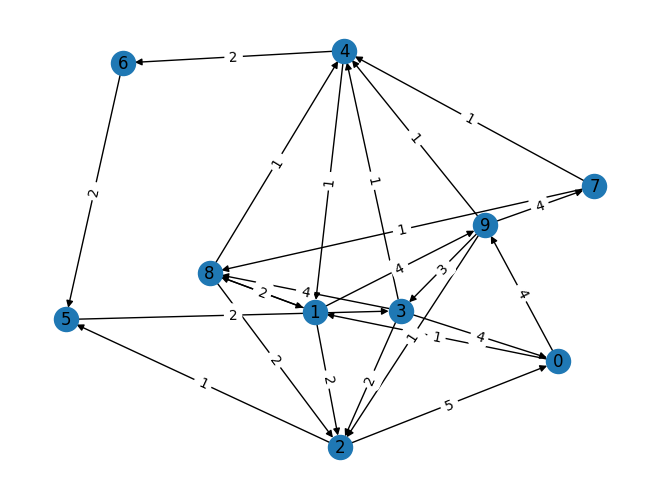

In [3]:
n = 10
m = 20
seed = 100
p = .3

random.seed(seed)

G = nx.gnp_random_graph(n, p, directed= True)
nx.set_edge_attributes(G, {e: {'weight': random.randint(1, 5)} for e in G.edges})
pos = nx.spring_layout(G, seed = seed)

nx.draw(G, pos, with_labels = True)
nx.draw_networkx_edge_labels(G,pos,edge_labels=nx.get_edge_attributes(G,'weight'));

weights = {}
for i,j in G.edges:
  weights[(i,j)] = nx.to_dict_of_dicts(G)[i][j]['weight']
  weights[(j,i)] = nx.to_dict_of_dicts(G)[i][j]['weight']

In [4]:
model = ConcreteModel()

model.I = RangeSet(0,n-1)

model.C = Param(model.I, model.I, initialize = weights)

model.X = Var(model.I, model.I, within = NonNegativeIntegers)

# Each edge has at most its maximum capacity

def con1_rule(model,i,j):
  if (i,j) in G.edges:
    return model.X[(i,j)] <= model.C[(i,j)]
  else:
    return Constraint.Skip
model.con1 = Constraint(model.I, model.I, rule = con1_rule)

# Each edge's input capacity matches its output capacity

def con2_rule(model,i):
  return sum(model.X[(i,j)] for j in model.I if (i,j) in G.edges) == sum(model.X[(j,i)] for j in model.I if (j,i) in G.edges)
model.con2 = Constraint(model.I, rule = con2_rule)

# Objective function

model.obj = Objective(expr = sum(model.X[(i,j)] for i in model.I for j in model.I if (i,j) in G.edges), sense = maximize)

# Solving model
Solve(model,'cbc')

Solution is Optimal
Solve Time:  0.01


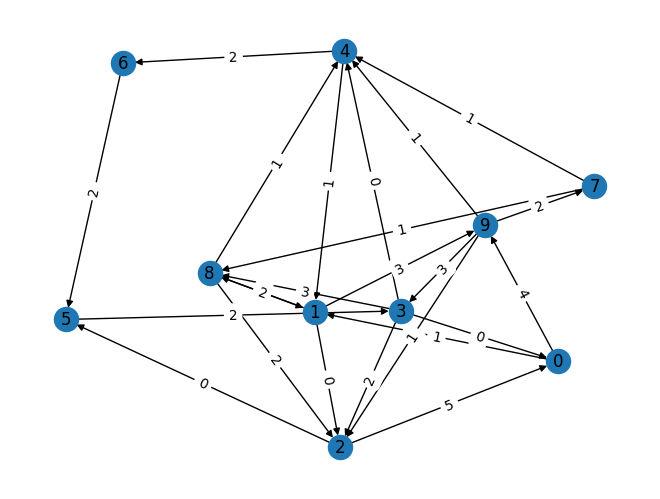

In [5]:
random.seed(seed)

sol = {(i,j):k for (i,j),k in model.X.extract_values().items() if k != None}

p = .3
G = nx.gnp_random_graph(n, p, directed= True)
nx.set_edge_attributes(G, {e: {'weight': int(sol[e])} for e in G.edges})
#pos = nx.spring_layout(G, seed = seed)

nx.draw(G, pos, with_labels = True)
nx.draw_networkx_edge_labels(G,pos,edge_labels=nx.get_edge_attributes(G,'weight'));

# **Vertex Cover Problem**

Find the smallest set of nodes ($N$) such that each edge ($E$) in the graph is incident to at least one node in the set.

\begin{aligned}
& \text{minimize} & & \sum_{i \in N} X_{i} \\
& \text{subject to} & &  X_{i} + X_{j} \geq 1 \quad & \forall (i, j) \in E \\
& & & X_{ij} \in \{0,1\}
\end{aligned}

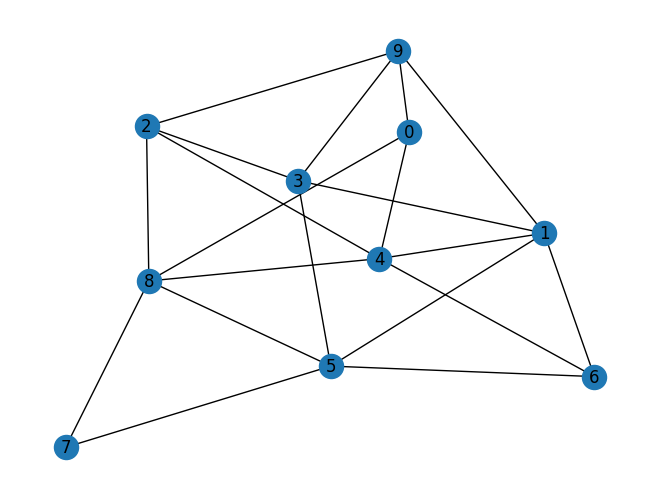

In [130]:
n = 10
m = 20
seed = 000

G = nx.gnm_random_graph(n,m,seed)
pos = nx.spring_layout(G, seed = seed)
nx.draw(G, pos, with_labels = True)

In [131]:
model = ConcreteModel()

model.I = range(len(G.edges)+1)

model.J = range(len(G.nodes))

model.X = Var(model.J, within = Boolean)

# Each edge has at least one vertex in the set of used vertices

def con1_rule(model,i,j):
  if (i,j) in G.edges:
    return model.X[i] + model.X[j] >= 1
  else:
    return Constraint.Skip
model.con1 = Constraint(model.I, model.I, rule = con1_rule)

# Objective function minimizing total number of used vertices

model.obj = Objective(expr = sum(model.X[j] for j in model.J))

# Solving model
Solve(model,'cbc')

Solution is Optimal
Solve Time:  0.01


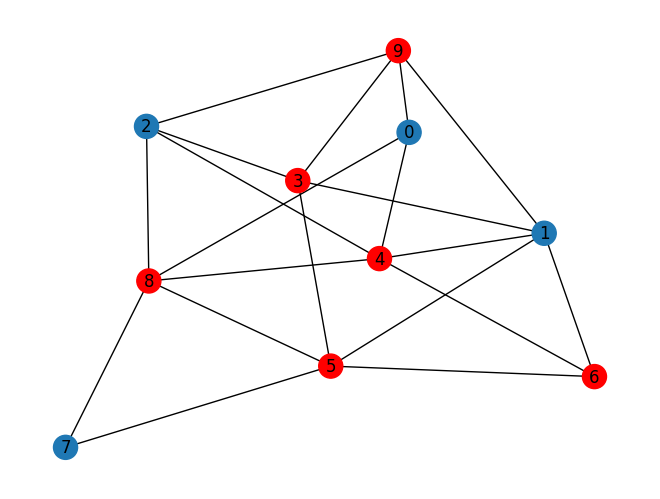

In [133]:
sol = {(i):k for (i),k in model.X.extract_values().items() if k == 1}

color = []
for i in list(G.nodes):
  if i in sol.keys():
    color.append('r')
  else:
    color.append('#1f78b4')

nx.draw(G, pos, with_labels = True, node_color = color)